## Testing our newly collected data

In [1]:
import pandas as pd

## Pre-preprocessing - Need to clean my json-like file so that it becomes a json file

Need to clean my collect file

tr '\n' ' '

sed -i 's/""/""/g' twitter.json

sed -i 's/\([^{:]\)"\([^:}]\)/\1\2/g' twitter.json 

sed -i 's/}{/,/g' twitter.json 

perl -pe 's/(?<!{|("(,|:)))"(?!((?:,|:)"|}))//g' twitter.json > twitter2.json

fake quotation marks

sed -i 's/“//g' test.json 

sed -i 's/”//g' test.json 

someone put a backslash before my closing " for the json string - very frustrating

sed -i 's/\\//g' test.json

In [2]:
#had to manually edit file to add wrapper labelled content
df = pd.read_json('test.json')

In [4]:
df[:5]

,content
0,@ang__johnson I worked in nhs and there were l...
1,@dann58638436 @ShockTraumaRN @Jaytee116James @...
10,@Big_Rob_Mac @beverleyturner @thismorning Of c...
100,@FederalFrank @KRNV Just as many vaccinated di...
1000,@thevivafrei @CPHO_Canada She's crazy and shou...


In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

2022-05-14 19:38:42.811495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 19:38:42.811512: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Preprocessing

In [4]:
stop = set(stopwords.words('english'))
lm = WordNetLemmatizer()
def remove_stop(text):
    text = text.lower().split()
    text = [word for word in text if word not in stop]
    return ' '.join(text)

In [5]:
print(datetime.now())
processed_tweets = []
for tweet in df['content']:
    prep_tweet = re.sub(r'(\w+://\S+)','',tweet.lower())#https?[:/\.a-zA-Z]+
    #prep_tweet = re.sub(r'http\w+','',prep_tweet)
    prep_tweet = re.sub(r'&amp','',prep_tweet)
    prep_tweet = re.sub(r'[^\w\s]','',prep_tweet) #[|.,!\[\]?$:;\-+*=\'()%...\"/@#_]+
    prep_tweet = re.sub(r'[\d_]','',prep_tweet)
    #prep_tweet = re.sub(r'\d+','',prep_tweet) #consider if we want numbers
    prep_tweet = remove_stop(prep_tweet)
    #prep_tweet = word_tokenize(prep_tweet)
    prep_tweet = ' '.join([lm.lemmatize(word) for word in prep_tweet.split(' ')])
    prep_tweet = prep_tweet.replace('nh','nhs') #I noticed this was being lemmatized, even though it is an important term
    processed_tweets.append(prep_tweet)
print(datetime.now())

2022-05-14 19:38:50.316857
2022-05-14 19:38:52.692475


In [10]:
processed_tweets[:5]

['angjohnson worked nhs load job going vaccination centre convid contract year far',
 'dann shocktraumarn jayteejames jameslynchgtc aspalaasnasntyr andylumm mcfunny djchicus richykirsh willard fvckyourfear krebiozen provaxtexan jimeeliberty skepticalmutant jonathanhsannah andrewlazarus tonybaduy doom msabouri volpiranyas ogilville alexona isthisnetaken premierimproves maloj tryingmypatient chimera itisjustmebabe waltertallen diar realshocks kathcats elizabeth skepticalprune shocktraumanp kcgetaway randomurban wendyorent nockit pompiliamanda zaynjaffer plhartungrn raouldukeerik spoonsterboss piattpicks fannyi sammy uofmaryland texastech youre guessing possibility vaccine cause dont even know covid hmmmm',
 'bigrobmac beverleyturner thismorning course bev love dodgy doc',
 'federalfrank krnv many vaccinated died dont fool',
 'thevivafrei cphocanada shes crazy locked']

In [20]:
wordset = set(' '.join(processed_tweets).split())

In [21]:
wordset

{'london',
 'outlier',
 'weather',
 'caylajharris',
 'doctorlix',
 'hyperplasia',
 'guan',
 'propganda',
 'respectful',
 'ernstvingerhoe',
 'prayusa',
 'swarming',
 'boarding',
 'ethnic',
 'basecamp',
 'newsjunkiegreen',
 'body',
 'sensible',
 'truenorthcentre',
 'scotus',
 'kempmat',
 'jealous',
 'superstition',
 'unanimous',
 'fraudci',
 'lifetime',
 'balance',
 'barryonash',
 'joebiden',
 'wideeyed',
 'mrfuriousrn',
 'bst',
 'ignorant',
 'malone',
 'obscurer',
 'flipflopping',
 'third',
 'matrixsimulated',
 'obese',
 'antother',
 'idespisejayleno',
 'robschneider',
 'trumpsbiglie',
 'psychological',
 'fkansteiner',
 'valuable',
 'friday',
 'microclots',
 'raise',
 'radrachelanne',
 'intercultural',
 'jjj',
 'hideous',
 'altmankimber',
 'bereaved',
 'nycvaccineforall',
 'cartabellotta',
 'nhssuk',
 'boycotttimhortons',
 'miniscule',
 'kathmlee',
 'continues',
 'unfriendly',
 'forecasting',
 'nielsutherland',
 'hyderabad',
 'wingnut',
 'denier',
 'public',
 'enclosed',
 'hadthings',
 

In [22]:
len(wordset)

18906

In [9]:
processed_tweets = processed_tweets[:10000]

Had to shrink my dataset - computer didnt have enough RAM

## Create a wordcloud based on the TDIDF values of the whole dataset

In [10]:
tfidf = TfidfVectorizer()
vecs = tfidf.fit_transform(processed_tweets)
feature_names = tfidf.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
tfidf_df = pd.DataFrame(lst1, columns=feature_names)

In [12]:
tfidf_df.T.sum(axis=1)

aa         0.454044
aaa        0.234341
aajtak     0.397477
aamina     0.367151
aap        0.993476
             ...   
𝚏𝚛𝚘𝚖       0.347136
𝚙𝚛𝚘𝚝𝚎𝚌𝚝    0.347136
𝚜𝚝𝚒𝚕𝚕      0.347136
𝚟𝚊𝚌𝚌𝚒𝚗𝚎    0.347136
𝚢𝚘𝚞        0.347136
Length: 18885, dtype: float64

In [13]:
wc_tfidf = WordCloud(max_words=100,width=2000,height=1000).generate_from_frequencies(tfidf_df.T.sum(axis=1))

In [15]:
wc_tfidf.to_file('tfidf_wc.png')

# Create a Latent Dirichlet Allocation model and apply it to the data

### Create a simple BoW

In [79]:
processed_tweets

['angjohnson worked nhs load job going vaccination centre convid contract year far',
 'dann shocktraumarn jayteejames jameslynchgtc aspalaasnasntyr andylumm mcfunny djchicus richykirsh willard fvckyourfear krebiozen provaxtexan jimeeliberty skepticalmutant jonathanhsannah andrewlazarus tonybaduy doom msabouri volpiranyas ogilville alexona isthisnetaken premierimproves maloj tryingmypatient chimera itisjustmebabe waltertallen diar realshocks kathcats elizabeth skepticalprune shocktraumanp kcgetaway randomurban wendyorent nockit pompiliamanda zaynjaffer plhartungrn raouldukeerik spoonsterboss piattpicks fannyi sammy uofmaryland texastech youre guessing possibility vaccine cause dont even know covid hmmmm',
 'bigrobmac beverleyturner thismorning course bev love dodgy doc',
 'federalfrank krnv many vaccinated died dont fool',
 'thevivafrei cphocanada shes crazy locked',
 'brooklynyyy vaccine effective still used',
 'deborahw toniabuxton muschampprimary agreed also seasonal flu jab mother f

In [75]:
cvec = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorised = cvec.fit_transform(processed_tweets)

In [17]:
from pprint import pprint

In [80]:
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(data_vectorised)

In [29]:
print("Log Likelihood: ", lda_model.score(data_vectorised))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorised))

Log Likelihood:  -782299.232443466
Perplexity:  1318.7496800364918


Perplexity is much lower than the 100 tweet sample, but likelihood is significantly lower too

## Use grid search to find optimal paramaters 

In [24]:
search_params = {'n_components': [5,10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorised)

best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorised))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -163816.47407619184
Model Perplexity:  962.189687074568


Very disappointing results - only one topic is the best model. Not surprising because we had specific search terms, so there will naturally be a significant overlap between all documents in our dataset

In [ ]:
search_params = {'n_components': [1,3,5,], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation(n_jobs=5)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(data_vectorised)

#best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", model.best_estimator_.perplexity(data_vectorised))

In [31]:
print("Model Perplexity: ", model.best_estimator_.perplexity(data_vectorised))

Model Perplexity:  916.9203672794317


### Show the top keywords from our one model

In [72]:
# Show top n keywords for each topic
def show_topics(vectoriser=cvec, lda_model=lda_model, n_words=20):
    keywords = np.array(cvec.get_feature_names_out())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords



In [62]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=model.best_estimator_, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,covid,vaccine,vaccinated,people,get,death,vaccination,dont,one,like,still,know,got,mask,year


# Process our results to destroy our best topic

In [33]:
df_topic_keywords.iloc[0]

Word 0           covid
Word 1         vaccine
Word 2      vaccinated
Word 3          people
Word 4             get
Word 5           death
Word 6     vaccination
Word 7            dont
Word 8             one
Word 9            like
Word 10          still
Word 11           know
Word 12            got
Word 13           mask
Word 14           year
Name: Topic 0, dtype: object

In [48]:
for word in df_topic_keywords.iloc[0].values:
    print(word == 'year')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


In [51]:
new_processed_tweets = []
for tweet in processed_tweets:
    for word in df_topic_keywords.iloc[0].values:
        tweet = tweet.replace(word,'')
    new_processed_tweets.append(tweet)

In [52]:
new_processed_tweets[:5]

['angjohnson worked nhs load job going  centre convid contract  far',
 'dann shocktraumarn jayteejames jameslynchgtc aspalaasnasntyr andylumm mcfunny djchicus richykirsh willard fvckyourfear krebiozen provaxtexan jimeeliberty skepticalmutant jonathanhsannah andrewlazarus tonybaduy doom msabouri volpiranyas ogilville alexona isthisnetaken premierimproves maloj tryingmypatient chimera itisjustmebabe waltertallen diar realshocks kathcats elizabeth skepticalprune shocktraumanp kcaway randomurban wendyorent nockit pompiliamanda zaynjaffer plhartungrn raouldukeerik spoonsterboss piattpicks fannyi sammy uofmaryland texastech youre guessing possibility  cause  even   hmmmm',
 'bigrobmac beverleyturner thismorning course bev love dodgy doc',
 'federalfrank krnv many  died  fool',
 'thevivafrei cphocanada shes crazy locked']

In [53]:
new_data_vect = cvec.fit_transform(new_processed_tweets)

In [54]:
new_lda_output = lda_model.fit_transform(new_data_vect)

In [56]:
print("Log Likelihood: ", lda_model.score(new_data_vect))
print("Perplexity: ", lda_model.perplexity(new_data_vect))

Log Likelihood:  -682944.4058426173
Perplexity:  2005.6672912501374


In [58]:
search_params = {'n_components': [1,3,5,], 'learning_decay': [.5, .7, .9]}
model.fit(new_data_vect)

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", model.best_estimator_.perplexity(new_data_vect))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 1}
Best Log Likelihood Score:  -133320.62836220427
Model Perplexity:  1315.5250638673106


In [63]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=model.best_estimator_, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,would,shot,need,many,time,ting,booster,every,even,work,child,take,data,health,never


The most heavily influential words now that the top 15 were deleted 

Gonna tune topics by hand - gridsearch not doing well enough on focused topic

In [67]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,question,justintrudeau,expert,trudeau,john,cdcgov,usfda,justin,supposed,tory,ford,doug,disgrace,democracy,answering
Topic 1,booster,may,fully,help,day,thank,loss,find,end,havent,best,thanks,shot,india,link
Topic 2,trump,life,please,biden,two,die,via,china,youre,abortion,freedom,lost,ebay,check,canada
Topic 3,free,cdc,called,start,part,backtolife,trust,tweet,elderly,answer,despite,fauci,highly,looking,strain
Topic 4,much,right,week,come,medical,bad,time,every,science,yet,would,already,efficacy,lot,jedediahbila
Topic 5,believe,coronavirus,dead,leovaradkar,understand,left,war,biden,control,access,next,hand,total,increase,blame
Topic 6,cant,read,safe,really,keep,think,kreekcraft,stay,bogochisaac,mandate,american,fact,person,potus,majority
Topic 7,country,way,population,wear,work,dos,reason,thrasherxy,care,actually,also,around,others,immune,global
Topic 8,thread,pfizer,said,time,body,made,great,received,lie,dose,mrna,least,remember,gbnews,given
Topic 9,never,realcandaceo,ting,flu,ive,thing,there,jab,tell,thats,dying,though,saying,vaxxed,different


In [69]:
import pyLDAvis
import pyLDAvis.sklearn
%matplotlib inline

In [85]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorised, cvec, mds='tsne')
panel

/home/mori/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/mori/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/mori/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/mori/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.1

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  20.278477
9       0.648955  71.707100       2        1  14.168850
5      71.019684   9.971006       3        1  13.138042
7       3.785981  33.185135       4        1  12.024051
3     -42.666500  -9.222070       5        1  11.789054
1      -3.621689 -43.526516       6        1   6.667778
0      -3.632402  -4.171708       7        1   6.436024
2     -36.584400  35.804413       8        1   6.088486
6      44.391380  50.615383       9        1   6.046296
4      40.235809 -31.591665      10        1   3.362942, topic_info=            Term         Freq        Total Category  logprob  loglift
442        death   802.000000   802.000000  Default  30.0000  30.0000
1960     vaccine  3887.000000  3887.000000  Default  29.0000  29.0000
393        covid  4598.000000  4598.000000  Default  28.0000  28.0000
1957  vaccinated  1477.000000  1477.000000  Default  27.0000  27.0000
1867      thread   318.000000   318.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
504       doctor   138.352260   169.930641  Topic10  -3.2759   3.1868
1420     problem    60.217860    99.830736  Topic10  -4.1078   2.8868
994   kreekcraft    64.513063   174.178723  Topic10  -4.0389   2.3991
631         fake    29.776009    54.232301  Topic10  -4.8120   2.7928
1515      refuse    27.024183    50.284040  Topic10  -4.9090   2.7714

[493 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         4  0.975549       abc
2         2  0.980669      able
3         5  0.995531  abortion
11        2  0.141970    access
11        7  0.851819    access
...     ...       ...       ...
2082      5  0.993048       yet
2087      2  0.420365     youre
2087      5  0.397225     youre
2087      8  0.181258     youre
2089      1  0.990162     youve

[647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 6, 8, 4, 2, 1, 3, 7, 5])

In [76]:
len(data_vectorised.toarray()[0])

2094

In [84]:
len(lda_model.components_[0])

2094

In [86]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,booster,immunity,received,data,thrasherxy,report,unvaccinated,leovaradkar,ever,yes,hepatitis,least,natural,testing,system
Topic 1,vaccine,covid,shot,effective,sentedcruz,first,data,order,much,there,military,via,moderna,heart,efficacy
Topic 2,sorry,therealrhllor,life,die,choice,tell,made,hope,likely,better,get,worse,soon,remember,ill
Topic 3,vaccine,covid,trump,died,risk,biden,pfizer,people,repvaldemings,yet,study,many,fact,woman,wont
Topic 4,question,expert,doctor,hospital,understand,justintrudeau,trudeau,john,justin,supposed,hhsgov,tory,kreekcraft,ford,doug
Topic 5,vaccine,covid,vaccination,child,get,need,make,time,day,read,way,safe,work,want,anyone
Topic 6,thread,please,million,side,effect,could,loss,home,money,vaccine,covid,protection,billion,event,pandemic
Topic 7,covid,death,vaccinated,health,vaccine,vaccination,rate,kid,show,case,people,free,news,come,age
Topic 8,covid,vaccinated,get,people,mask,vaccine,got,one,say,like,dont,said,would,know,never
Topic 9,vaccine,covid,still,people,well,didnt,know,virus,keep,long,even,vaccinated,without,dont,time


There are a number of possibly distinct sub topics here; the full dataset is reloaded as the memory issues were possibly just dfidf related

# Re pre pre process

In [87]:
df

,content
0,@ang__johnson I worked in nhs and there were l...
1,@dann58638436 @ShockTraumaRN @Jaytee116James @...
10,@Big_Rob_Mac @beverleyturner @thismorning Of c...
100,@FederalFrank @KRNV Just as many vaccinated di...
1000,@thevivafrei @CPHO_Canada She's crazy and shou...
...,...
9995,"Nolte: 1M Dead from Coronavirus, 60% Under Bid..."
9996,@biologistjim @GovAndyBeshear No because they ...
9997,Should the COVID-19 injections be renamed to s...
9998,@BuckSexton Maybe because almost 1/2 the peopl...


In [90]:
print(datetime.now())
full_processed_tweets = []
for tweet in df['content']:
    prep_tweet = re.sub(r'(\w+://\S+)','',tweet.lower())#https?[:/\.a-zA-Z]+
    #prep_tweet = re.sub(r'http\w+','',prep_tweet)
    prep_tweet = re.sub(r'&amp','',prep_tweet)
    prep_tweet = re.sub(r'[^\w\s]','',prep_tweet) #[|.,!\[\]?$:;\-+*=\'()%...\"/@#_]+
    prep_tweet = re.sub(r'[\d_]','',prep_tweet)
    #prep_tweet = re.sub(r'\d+','',prep_tweet) #consider if we want numbers
    prep_tweet = remove_stop(prep_tweet)
    #prep_tweet = word_tokenize(prep_tweet)
    prep_tweet = ' '.join([lm.lemmatize(word) for word in prep_tweet.split(' ')])
    prep_tweet = prep_tweet.replace('nh','nhs') #I noticed this was being lemmatized, even though it is an important term
    full_processed_tweets.append(prep_tweet)
print(datetime.now())

2022-05-14 11:18:42.535489
2022-05-14 11:18:43.875280


In [91]:
len(full_processed_tweets)

32906

In [92]:
full_data_vect = cvec.fit_transform(full_processed_tweets)
new_lda_output = lda_model.fit_transform(full_data_vect)
print("Log Likelihood: ", lda_model.score(full_data_vect))
print("Perplexity: ", lda_model.perplexity(full_data_vect))

Log Likelihood:  -3008088.4827736774
Perplexity:  1779.9048819284274


Very very bad likelihood

In [93]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,covid,vaccine,get,mask,people,vaccinated,kid,boosted,one,fully,right,died,life,wear,global
Topic 1,covid,vaccinated,death,get,people,vaccination,case,didnt,million,said,pandemic,could,still,rate,read
Topic 2,vaccine,covid,people,pfizer,still,risk,dont,data,need,know,stop,infection,like,work,one
Topic 3,covid,say,would,well,vaccine,get,health,one,month,people,vaccinated,better,know,dos,dose
Topic 4,taking,realcandaceo,yet,old,vaccine,yes,usa,sentedcruz,covid,via,everything,world,almost,billion,moderna
Topic 5,without,canada,vaccine,theyre,cdc,government,australia,told,kill,seen,health,blood,human,total,start
Topic 6,got,never,vaccinated,time,like,dont,youre,covid,week,getting,think,sick,flu,good,ive
Topic 7,vaccine,covid,biden,vaccination,trump,mandate,coronavirus,please,american,thread,card,would,certificate,dead,job
Topic 8,sorry,nathaliejacoby,two,therealrhllor,question,justintrudeau,loss,expert,trudeau,john,justin,tory,ford,doug,supposed
Topic 9,covid,vaccine,child,make,effect,long,whitehouse,immunity,side,sure,symptom,far,free,country,natural


In [95]:
panel = pyLDAvis.sklearn.prepare(lda_model, full_data_vect, cvec, mds='tsne')
panel

/home/mori/.local/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/mori/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/mori/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/mori/.local/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentat

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
2      32.420952   8.115230       1        1  14.586090
1       0.648955  71.707100       2        1  14.477771
3      71.019684   9.971006       3        1  12.499487
0       3.785981  33.185135       4        1  12.447586
6     -42.666500  -9.222070       5        1  10.825870
7      -3.621689 -43.526516       6        1  10.463881
9      -3.632402  -4.171708       7        1   9.558921
5     -36.584400  35.804413       8        1   6.040350
4      44.391380  50.615383       9        1   5.597628
8      40.235809 -31.591665      10        1   3.502416, topic_info=             Term          Freq         Total Category  logprob  loglift
4656      vaccine  13481.000000  13481.000000  Default  30.0000  30.0000
1097        death   2410.000000   2410.000000  Default  29.0000  29.0000
1817          got   1549.000000   1549.000000  Default  28.0000  28.0000
4652   vaccinated   4833.000000   4833.000000  Default  27.0000  27.0000
1766          get   4062.000000   4062.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
1796  globedebate     69.644077     70.530920  Topic10  -5.3089   3.3391
278    artyshouse     68.248431     69.135267  Topic10  -5.3291   3.3388
874    condolence     66.894420     67.781262  Topic10  -5.3492   3.3385
3932        shame     66.133365     67.020322  Topic10  -5.3606   3.3384
576    bucksexton    124.231818    294.835182  Topic10  -4.7301   2.4875

[480 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         2  0.993739       abc
4         5  0.997481      able
5         4  0.995221  abortion
45        3  0.434035  actually
45        7  0.199353  actually
...     ...       ...       ...
4937      5  0.998955     youre
4941      7  0.991638     youve
4944     10  0.997029   zchagla
4947      4  0.177666      zero
4947      7  0.817265      zero

[612 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 7, 8, 10, 6, 5, 9])

Results are still not informative
Will look at other methods of processing data to create greater relevance in topic modelling (n-grams)

# Create a dictionary of only n-grams

In [64]:
bigram = gensim.models.Phrases(full_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
#trigram = gensim.models.Phrases(bigram[full_processed_tweets], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
#trigram_mod = gensim.models.phrases.Phraser(trigram)

NameError: name 'full_words_list' is not defined

In [173]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [174]:
full_words_list = [[word for word in tweet.split()] for tweet in full_processed_tweets]

In [175]:
out = make_bigrams(full_words_list)

In [176]:
len([' '.join(tweet) for tweet in out if '_' in ' '.join(tweet)])

14965

In [178]:
trigrammed_tweet = [' '.join(tweet) for tweet in out if '_' in ' '.join(tweet)]

In [185]:
out = [[word for word in tweet.split() if '_' in word] for tweet in trigrammed_tweet]

In [188]:
new_out = []
for col in out:
    for bgram in col:
        new_out.append(bgram)

In [189]:
new_out

['dann_shocktraumarn',
 'jayteejames_jameslynchgtc',
 'aspalaasnasntyr_andylumm',
 'djchicus_richykirsh',
 'willard_fvckyourfear',
 'krebiozen_provaxtexan',
 'jimeeliberty_skepticalmutant',
 'jonathanhsannah_andrewlazarus',
 'tonybaduy_doom',
 'msabouri_volpiranyas',
 'ogilville_alexona',
 'isthisnetaken_premierimproves',
 'maloj_tryingmypatient',
 'chimera_itisjustmebabe',
 'waltertallen_diar',
 'realshocks_kathcats',
 'elizabeth_skepticalprune',
 'shocktraumanp_kcgetaway',
 'randomurban_wendyorent',
 'nockit_pompiliamanda',
 'zaynjaffer_plhartungrn',
 'raouldukeerik_spoonsterboss',
 'piattpicks_fannyi',
 'sammy_uofmaryland',
 'beverleyturner_thismorning',
 'seasonal_flu',
 'houstonchron_sentedcruz',
 'caylajharris_dispatchalerts',
 'lawful_order',
 'recovers_quickly',
 'omicron_ba',
 'united_state',
 'archival_quality',
 'art_print',
 'art_ukraine',
 'gallerywall_abortion',
 'music_trump',
 'museum_gaming',
 'biden_wallart',
 'china_comedy',
 'scotus_roevwade',
 'via_ebay',
 'month_a

In [195]:
gram_tweets = [' '.join(tweet) for tweet in out]

In [196]:
ngramvec = cvec.fit_transform(gram_tweets)
new_lda_output = lda_model.fit_transform(ngramvec)
print("Log Likelihood: ", lda_model.score(ngramvec))
print("Perplexity: ", lda_model.perplexity(ngramvec))

Log Likelihood:  -308539.08619321324
Perplexity:  388.4280471223752


In [197]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,without,send,australia,canada,certificate,digital,card,paper,usa,passport,scan,modi,korea,link,click
Topic 1,heart,andylumm,attack,mcfunny,zaynjaffer,wendyorent,skepticalmutant,volpiranyas,provaxtexan,realshocks,pompiliamanda,raouldukeerik,piattpicks,shocktraumanp,plhartungrn
Topic 2,old,year,big,pharma,causing,wildhoney,baby,mremt,thread,test,formula,boosted,drjamesolsson,trial,numerous
Topic 3,question,john,woman,trudeau,justin,ford,doug,tory,pregnant,biden,russia,christian,prayed,miltu,jedediahbila
Topic 4,immunity,via,natural,pfizer,dead,nolte,foxnews,age,dose,group,life,single,namo,month,app
Topic 5,wear,mask,sentedcruz,houstonchron,stay,caylajharris,dispatchalerts,safe,adverse,effective,news,sense,among,new,order
Topic 6,mask,wearing,health,public,hhsgov,home,medical,babineer,social,hhsregion,kyrie,cruz,ted,available,medium
Topic 7,potus,bill,gate,blood,eucommission,vonderleyen,tested,positive,thank,clot,gene,corona,better,ameracadpeds,virus
Topic 8,effect,sorry,immune,side,system,therealrhllor,loss,long,term,week,study,cdnrefusenik,johnson,code,registered
Topic 9,whitehouse,body,choice,protein,zchagla,office,took,spike,repvaldemings,africa,conspiracy,administered,christinapushaw,picardonhsealth,south


In [199]:
lda_model.components_

array([[ 0.10000042,  0.1       ,  0.10000027, ...,  8.34216382,
         0.1       ,  0.10000611],
       [ 0.1       ,  0.10002715,  0.10000001, ...,  0.1       ,
         0.1       ,  0.1       ],
       [ 0.1       ,  0.1       ,  0.1       , ...,  0.10000442,
         0.1       , 10.72760767],
       ...,
       [ 0.10000038,  0.10001846,  0.1       , ...,  0.10000146,
         9.8286369 ,  0.1       ],
       [ 0.10000122,  0.10001304,  0.1       , ...,  0.100003  ,
         0.1       ,  0.10000696],
       [ 0.1000013 ,  0.10001105,  0.10000057, ...,  0.1000006 ,
         0.1       ,  0.1       ]])

In [200]:
cvec.get_feature_names_out()

array(['abc', 'able', 'abortion', ..., 'zealand', 'zebrastripesusa',
       'zoeharcombe'], dtype=object)

Vectoriser isnt collecting bigrams - fixed below

In [209]:
cvec = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]+_[a-zA-Z0-9]+',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
vect_ngram = cvec.fit_transform(gram_tweets)
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(vect_ngram)

In [210]:
cvec.get_feature_names_out()

array(['abc_news', 'able_acquire', 'abortion_music', 'abortion_racism',
       'abruptly_resigns', 'absolutely_unacceptable', 'according_jhus',
       'acute_hepatitis', 'administered_represents',
       'admitted_doublevaccinated', 'adriandix_johnrustadbc',
       'adverse_effect', 'adverse_event', 'adverse_reaction',
       'africa_first', 'age_group', 'ah_ad',
       'ahmedmekallach_maximebernier', 'alexona_isthisnetaken',
       'alexona_provaxtexan', 'alfredstatesx_iclib', 'allergic_reaction',
       'ameracadpeds_modernmommydoc', 'ameracadpeds_usfda',
       'analysis_federal', 'analyze_fact',
       'andrewlazarus_aspalaasnasntyr', 'andrewlazarus_tonybaduy',
       'andrewrd_patriot', 'andylumm_mcfunny', 'andylumm_wendyorent',
       'animallife_minigoldendoodl', 'annejourney_randall',
       'answering_question', 'anti_vaxxers',
       'antibodydependent_enhsancement', 'appalachiaone_realdante',
       'application_regulator', 'approval_process', 'archival_quality',
       'are

In [211]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,wear_mask,side_effect,blood_clot,feel_better,make_sense,sorry_hear,dos_administered,family_member,gene_therapy,corona_virus,herd_immunity,common_cold,havent_gotten,operation_warp,pcr_test
Topic 1,immune_system,spike_protein,foxnews_speakerpelosi,baby_formula,adverse_reaction,clinical_trial,tallyannae_whitehouse,ted_cruz,nathaliejacoby_joncoopertweets,breast_milk,immune_response,christinapushaw_repvaldemings,zchagla_globedebate,nursing_home,hundred_thousand
Topic 2,caylajharris_dispatchalerts,houstonchron_sentedcruz,mark_beast,prayed_pfizer,seen_christian,mremt_wildhoney,week_cdnrefusenik,month_ago,started_question,relief_caught,kyrie_stay,honorable_discharge,organic_hurt,saferstoresorg_storiesofinjury,bed_two
Topic 3,year_old,wearing_mask,sorry_loss,took_office,white_house,sentedcruz_realdailywire,common_sense,united_state,taekwondowoman_jeffkorchick,double_boosted,conspiracy_theory,viral_underclass,pm_modi,wore_mask,gas_price
Topic 4,nolte_dead,bill_gate,big_pharma,abc_news,technology_country,via_breitbartnews,rising_among,loved_one,stay_home,thank_god,license_key,every_single,precaution_dose,nih_license,causing_coming
Topic 5,therealrhllor_sorry,maker_moderna,abruptly_resigns,justin_trudeau,doug_ford,john_tory,via_epochtimes,single_order,factory_received,africa_first,traceyclarke_babineer,mortality_rate,sherrisview_faridjalali,answering_question,new_york
Topic 6,north_korea,tested_positive,summit_pm,pregnant_woman,safe_effective,vonderleyen_potus,vp_eucommission,joe_biden,namo_app,modi_hail,adverse_effect,pfizer_document,flexibility_trip,modi_call,roe_v
Topic 7,age_group,numerous_study,potentially_causing,adverse_event,vast_majority,serious_illness,msabouri_volpiranyas,ameracadpeds_usfda,waltertallen_diar,realshocks_kathcats,emergency_use,zaynjaffer_plhartungrn,piattpicks_fannyi,raouldukeerik_spoonsterboss,nockit_pompiliamanda
Topic 8,natural_immunity,public_health,body_choice,long_term,hhsgov_hhsregion,save_life,important_thread,boosted_development,stay_safe,bodily_autonomy,growing_share,early_treatment,thank_goodness,climate_change,social_distancing
Topic 9,card_without,send_dm,qr_scan,passport_without,digital_qr,certificate_paper,usa_uk,eu_australia,link_join,canada_click,miltu_jedediahbila,australia_canada,russia_eu,ireland_austria,send_message


Now this looks significantly more interesting
Time to grid search

In [212]:
search_params = {'n_components': [5,10,15,20,25], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation(n_jobs=6)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(vect_ngram)

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", model.best_estimator_.perplexity(vect_ngram))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -31779.128809846694
Model Perplexity:  344.57185145917646


In [213]:
search_params = {'n_components': [1,3,5], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation(n_jobs=6)
model = GridSearchCV(lda, param_grid=search_params)
model.fit(vect_ngram)

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", model.best_estimator_.perplexity(vect_ngram))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 1}
Best Log Likelihood Score:  -29866.523190576398
Model Perplexity:  478.71291121946507


Once again we resolve to a single topic - Gensim has a coherence model that may give better results 
## Use Gensim coherence model to find best fit
Also just move entirly to Gensim; test using both bigrams and single words

In [215]:
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [216]:
full_words_list[:5] #check this is still what we need for gensim - it is (list of list of words)

[['angjohnson',
  'worked',
  'nhs',
  'load',
  'job',
  'going',
  'vaccination',
  'centre',
  'convid',
  'contract',
  'year',
  'far'],
 ['dann',
  'shocktraumarn',
  'jayteejames',
  'jameslynchgtc',
  'aspalaasnasntyr',
  'andylumm',
  'mcfunny',
  'djchicus',
  'richykirsh',
  'willard',
  'fvckyourfear',
  'krebiozen',
  'provaxtexan',
  'jimeeliberty',
  'skepticalmutant',
  'jonathanhsannah',
  'andrewlazarus',
  'tonybaduy',
  'doom',
  'msabouri',
  'volpiranyas',
  'ogilville',
  'alexona',
  'isthisnetaken',
  'premierimproves',
  'maloj',
  'tryingmypatient',
  'chimera',
  'itisjustmebabe',
  'waltertallen',
  'diar',
  'realshocks',
  'kathcats',
  'elizabeth',
  'skepticalprune',
  'shocktraumanp',
  'kcgetaway',
  'randomurban',
  'wendyorent',
  'nockit',
  'pompiliamanda',
  'zaynjaffer',
  'plhartungrn',
  'raouldukeerik',
  'spoonsterboss',
  'piattpicks',
  'fannyi',
  'sammy',
  'uofmaryland',
  'texastech',
  'youre',
  'guessing',
  'possibility',
  'vaccin

In [220]:
bigrammed_word_list = make_bigrams(full_words_list)

In [224]:
bigrammed_word_list[7000:7020]

[['thread', 'worth', 'considering'],
 ['people',
  'illegally',
  'invading',
  'country',
  'get',
  'baby',
  'formuladont',
  'get',
  'tested',
  'covid',
  'disease',
  'mandated',
  'get',
  'vaccine',
  'get',
  'phone',
  'flown',
  'around',
  'country',
  'get',
  'money',
  'food',
  'place',
  'live',
  'health',
  'insurance',
  'got'],
 ['peggymeowmeow',
  'allybeaner_nobuddybuddy',
  'zchagla',
  'thats',
  'kid',
  'v',
  'omicron',
  'isnt',
  'pfizer',
  'data',
  'wasnt',
  'released',
  'foia',
  'isnt',
  'everyone',
  'data',
  'claiming'],
 ['martymakary',
  'whether',
  'covid',
  'vaccine',
  'use',
  'boris',
  'johnson',
  'even',
  'though',
  'suffering',
  'heavily',
  'covid',
  'got',
  'uk',
  'population',
  'vaccinated',
  'fastest',
  'europe',
  'even',
  'though',
  'unelected',
  'eurats',
  'tried',
  'steal',
  'vaccine',
  'well',
  'done',
  'boris'],
 ['amckunneke',
  'michaelpbreton',
  'spektralheart',
  'social',
  'credit',
  'system',
  

In [225]:
id2word = corpora.Dictionary(bigrammed_word_list)
corpus = [id2word.doc2bow(text) for text in bigrammed_word_list]

print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]]


In [226]:
gensim_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=1,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [228]:
pprint(gensim_lda_model.print_topics())

[(0,
  '0.073*"sentedcruz" + 0.062*"ap" + 0.054*"old" + 0.053*"oh" + '
  '0.052*"community" + 0.045*"drtedros" + 0.045*"young" + '
  '0.045*"caylajharris_dispatchalerts" + 0.045*"houstonchron_sentedcruz" + '
  '0.033*"individual"'),
 (1,
  '0.107*"year" + 0.082*"died" + 0.060*"made" + 0.055*"tell" + '
  '0.053*"everything" + 0.040*"sure" + 0.036*"th" + 0.035*"mostly" + '
  '0.031*"real" + 0.030*"he"'),
 (2,
  '0.152*"shot" + 0.133*"child" + 0.095*"may" + 0.055*"prevent" + '
  '0.046*"develop" + 0.040*"effective" + 0.039*"far" + '
  '0.038*"technology_country" + 0.037*"job" + 0.026*"parent"'),
 (3,
  '0.097*"realcandaceo" + 0.086*"new" + 0.083*"thing" + 0.060*"almost" + '
  '0.055*"maybe" + 0.051*"die" + 0.047*"lot" + 0.042*"bad" + 0.034*"ill" + '
  '0.034*"there"'),
 (4,
  '0.240*"vaccination" + 0.097*"work" + 0.083*"many" + 0.073*"really" + '
  '0.061*"theyre" + 0.056*"vax" + 0.037*"since" + 0.029*"another" + '
  '0.028*"free" + 0.022*"republican"'),
 (5,
  '0.160*"time" + 0.082*"full

In [231]:
# Compute Perplexity
print('\nPerplexity: ', gensim_lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  -19.164119333167918


In [239]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=gensim_lda_model, texts=bigrammed_word_list, dictionary=id2word, coherence='u_mass',processes=11)
#c_v model does not work for me for some reason 

In [240]:
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -8.132351163146954


In [249]:
topics = []
for topic in gensim_lda_model.print_topics():
    topics.append([term[term.index('*')+1:].replace('"','') for term in topic[1].split(' + ')])

In [254]:
pd.DataFrame(topics,index=[f'Topic {x}' for x in range(20)])

,0,1,2,3,4,5,6,7,8,9
Topic 0,sentedcruz,ap,old,oh,community,drtedros,young,caylajharris_dispatchalerts,houstonchron_sentedcruz,individual
Topic 1,year,died,made,tell,everything,sure,th,mostly,real,he
Topic 2,shot,child,may,prevent,develop,effective,far,technology_country,job,parent
Topic 3,realcandaceo,new,thing,almost,maybe,die,lot,bad,ill,there
Topic 4,vaccination,work,many,really,theyre,vax,since,another,free,republican
Topic 5,time,fully,come,around,family,control,due,baby,true,son
Topic 6,people,death,bucksexton,could,mandate,million,mask,spread,potus,le
Topic 7,vaccinated,like,im,got,getting,also,never,country,much,everyone
Topic 8,covid,vaccine,one,would,day,even,make,data,unvaccinated,actually
Topic 9,stop,government,told,expert,unvaxxed,ignorant,transmission,wearing,experiment,treated


Significantly less coherant than our previous models - 20 topics is probably way too many 

In [255]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [256]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=bigrammed_word_list, start=5, limit=20, step=5)

In [305]:
coherence_values

[-5.010834940923372, -7.311252577161488, -6.259953478799599]

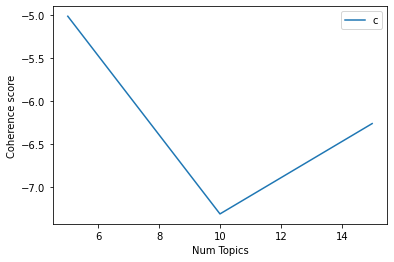

In [257]:
x = range(5, 20, 5)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

10 is the most coherent result we seem to get

In [258]:
gensim_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                                  random_state=1)

In [260]:
topics = []
for topic in gensim_lda_model.print_topics():
    topics.append([term[term.index('*')+1:].replace('"','') for term in topic[1].split(' + ')])
pd.DataFrame(topics,index=[f'Topic {x}' for x in range(10)])

,0,1,2,3,4,5,6,7,8,9
Topic 0,covid,vaccine,realcandaceo,shot,right,u,ap,baby,vaccinated,develop
Topic 1,get,covid,people,vaccinated,like,still,know,one,im,got
Topic 2,vaccine,covid,vaccination,biden,coronavirus,work,need,safe,whitehouse,take
Topic 3,covid,vaccine,vaccinated,death,people,vaccination,died,million,case,risk
Topic 4,day,covid,vaccine,th,good,thanks,ford_john,trudeau_doug,one,need
Topic 5,get,hope,sentedcruz,soon,dont,canadian,covid,well,go,joebiden
Topic 6,dont,people,covid,know,vaccinated,u,still,get,china,work
Topic 7,vaccine,covid,get,trump,taking,biden,say,mandate,u,mask
Topic 8,im,covid,vaccine,sorry,booster,therealrhllor,family,eligible,mremt_wildhoney,may
Topic 9,bogochisaac,line,nope,false,criminal,liar,pro,positive,paid,big_pharma


In [264]:
len(gensim_lda_model.get_topics())

10

    Get the term-topic matrix learned during inference.

    Returns

        The probability for each word in each topic, shape (num_topics, vocabulary_size).
    Return type

        numpy.ndarray



In [266]:
gensim_lda_model.print_topic(0,100)

'0.032*"covid" + 0.029*"vaccine" + 0.014*"realcandaceo" + 0.009*"shot" + 0.008*"right" + 0.007*"u" + 0.006*"ap" + 0.006*"baby" + 0.006*"vaccinated" + 0.006*"develop" + 0.006*"like" + 0.006*"would" + 0.006*"repvaldemings" + 0.005*"technology_country" + 0.005*"caylajharris_dispatchalerts" + 0.005*"houstonchron_sentedcruz" + 0.005*"know" + 0.005*"vaccination" + 0.004*"woman" + 0.004*"question" + 0.004*"looking" + 0.004*"course" + 0.004*"pregnant_woman" + 0.004*"decision" + 0.004*"people" + 0.004*"one" + 0.004*"youre" + 0.004*"get" + 0.004*"getting" + 0.004*"license_key" + 0.003*"two" + 0.003*"really" + 0.003*"gate" + 0.003*"whats" + 0.003*"anyone" + 0.003*"help" + 0.003*"choose" + 0.003*"side_effect" + 0.003*"double" + 0.003*"make" + 0.003*"dont" + 0.003*"link" + 0.003*"thats" + 0.003*"kid" + 0.003*"shortage" + 0.003*"wish" + 0.003*"way" + 0.003*"nothing" + 0.003*"currently" + 0.003*"effect" + 0.003*"pfizer" + 0.003*"got" + 0.003*"immune_system" + 0.003*"body" + 0.003*"feel" + 0.003*"stop

In [289]:
outs = [dict(zip([term[term.index('*')+1:].replace('"','') for term in gensim_lda_model.print_topic(x,100).split(' + ')],
                [term[:term.index('*')].replace('"','') for term in gensim_lda_model.print_topic(x,100).split(' + ')])) for x in range(10)]

In [290]:
outs

[{'covid': '0.032',
  'vaccine': '0.029',
  'realcandaceo': '0.014',
  'shot': '0.009',
  'right': '0.008',
  'u': '0.007',
  'ap': '0.006',
  'baby': '0.006',
  'vaccinated': '0.006',
  'develop': '0.006',
  'like': '0.006',
  'would': '0.006',
  'repvaldemings': '0.006',
  'technology_country': '0.005',
  'caylajharris_dispatchalerts': '0.005',
  'houstonchron_sentedcruz': '0.005',
  'know': '0.005',
  'vaccination': '0.005',
  'woman': '0.004',
  'question': '0.004',
  'looking': '0.004',
  'course': '0.004',
  'pregnant_woman': '0.004',
  'decision': '0.004',
  'people': '0.004',
  'one': '0.004',
  'youre': '0.004',
  'get': '0.004',
  'getting': '0.004',
  'license_key': '0.004',
  'two': '0.003',
  'really': '0.003',
  'gate': '0.003',
  'whats': '0.003',
  'anyone': '0.003',
  'help': '0.003',
  'choose': '0.003',
  'side_effect': '0.003',
  'double': '0.003',
  'make': '0.003',
  'dont': '0.003',
  'link': '0.003',
  'thats': '0.003',
  'kid': '0.003',
  'shortage': '0.003',
 

In [291]:
wc_list = [WordCloud(max_words=100,width=2000,height=1000).generate_from_frequencies(pd.Series(outs[x]).astype(float)) for x in range(len(outs))]

In [294]:
for x in range(len(wc_list)):
    wc_list[x].to_file(f'wc_topic{x}.png')

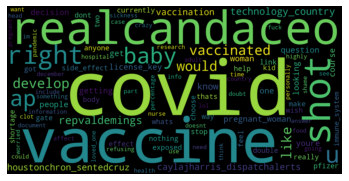

In [287]:
plt.imshow(wc_topic1, interpolation='bilinear')
plt.axis("off")
plt.show()

# Trying to use the bigrams again to generate more interesting results

## Using the same wordlists as before and back to sklearn

The likeliness of models increased as the topics decreased, but the perplexity increased. I will maybe go off perplexity instead

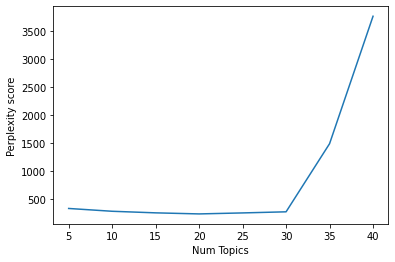

In [309]:
cvec = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]+_[a-zA-Z0-9]+',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
vect_ngram = cvec.fit_transform(gram_tweets)

perplexity = []
for i in range(5,45,5):
    lda_model = LatentDirichletAllocation(n_components=i,               # Number of topics
                                          learning_method='online',   
                                          random_state=1,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                          n_jobs = 9,               
                                         )
    lda_model.fit_transform(vect_ngram)
    perplexity.append(lda_model.perplexity(vect_ngram))
x = range(5,45,5)
plt.plot(x, perplexity)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.show()

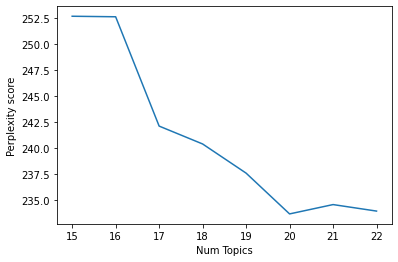

In [310]:
#fine tune the topics
perplexity = []
for i in range(15,23,1):
    lda_model = LatentDirichletAllocation(n_components=i,               # Number of topics
                                          learning_method='online',   
                                          random_state=1,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                          n_jobs = 9,               
                                         )
    lda_model.fit_transform(vect_ngram)
    perplexity.append(lda_model.perplexity(vect_ngram))
x = range(15,23,1)
plt.plot(x, perplexity)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.show()

It seems we have 20 topics when we only take bigrams 

In [311]:
lda_model = LatentDirichletAllocation(n_components=i,               # Number of topics
                                          learning_method='online',   
                                          random_state=1,          # Random state
                                          batch_size=128,            # n docs in each learning iter
                                          evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                          n_jobs = 9,               
                                         )
lda_model.fit_transform(vect_ngram)

array([[0.00206612, 0.00206612, 0.00206612, ..., 0.00206612, 0.00206612,
        0.00206612],
       [0.04545455, 0.04545455, 0.04545455, ..., 0.04545455, 0.04545455,
        0.04545455],
       [0.02272727, 0.02272727, 0.02272727, ..., 0.02272727, 0.02272727,
        0.02272727],
       ...,
       [0.02272727, 0.52272727, 0.02272727, ..., 0.02272727, 0.02272727,
        0.02272727],
       [0.52272727, 0.02272727, 0.02272727, ..., 0.02272727, 0.02272727,
        0.02272727],
       [0.02272727, 0.02272727, 0.02272727, ..., 0.02272727, 0.02272727,
        0.02272727]])

In [313]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords.iloc[:5]

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,wear_mask,side_effect,make_sense,family_member,herd_immunity,st_dose,mental_health,mollyploofkins_yes,warp_speed,social_distance,cant_afford,internal_document,dr_peter,washing_hand,good_vaccinefailure
Topic 1,wearing_mask,body_choice,hhsgov_hhsregion,survival_rate,nursing_home,wore_mask,dead_coronavirus,data_dump,repmaryfranson_govtimwalz,personal_medical,feeling_better,medical_professional,peach_christinapushaw,critical_thinking,billion_dollar
Topic 2,blood_clot,mremt_wildhoney,thank_god,tallyannae_whitehouse,honorable_discharge,gene_therapy,nathaliejacoby_joncoopertweets,corona_virus,common_cold,good_luck,healthcare_worker,darylhornsby_babineer,bill_giving,cruz_push,troop_refuse
Topic 3,white_house,pfizer_document,viral_underclass,emergency_use,pm_modi,south_african,pure_blood,firm_say,program_largest,edsaffle_whitehouse,global_virtual,lorrilala_neilcharles,asinister_girlpilled,cbeckj_usamriidca,trumpbangskids_chrisbbacon
Topic 4,nolte_dead,sorry_loss,joe_biden,abc_news,via_breitbartnews,qr_code,certificate_bosster,enabled_anyone,penny_curtis,provide_registered,rising_among,yr_old,early_treatment,potus_vp,occurring_among


In [314]:
df_topic_keywords.iloc[5:10]

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 5,bill_gate,foxnews_speakerpelosi,week_cdnrefusenik,serious_illness,sherrisview_faridjalali,christinapushaw_repvaldemings,ameracadpeds_usfda,ahmedmekallach_maximebernier,experimental_drug,knock_wood,producer_hid,effective_preventing,pushing_poison,hasnt_gotten,viral_load
Topic 6,immune_system,summit_pm,safe_effective,vonderleyen_potus,vp_eucommission,namo_app,modi_hail,adverse_effect,dos_administered,flexibility_trip,modi_call,drive_via,traceyclarke_babineer,distribution_via,precaution_dose
Topic 7,age_group,baby_formula,every_single,ted_cruz,breast_milk,fox_news,johnson_johnson,sore_throat,social_medium,wash_hand,crore_child,jerylbier_whitehouse,n_korea,via_namo,fear_mongering
Topic 8,public_health,trudeau_doug,ford_john,single_order,factory_received,africa_first,boosted_development,question_supposed,tory_disgrace,democracy_justin,tory_answering,climate_change,justintrudeau_justin,week_kyvoodoo,men_woman
Topic 9,big_pharma,miltu_jedediahbila,heart_attack,united_state,causing_coming,occurred_among,manninguscong_whitehouse,expected_american,analysis_federal,reaching_fully,expert_warn,immune_compromised,last_night,god_bless,charlenejo_foxnews


In [315]:
df_topic_keywords.iloc[10:15]

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 10,art_print,msabouri_volpiranyas,realshocks_kathcats,waltertallen_diar,piattpicks_fannyi,zaynjaffer_plhartungrn,raouldukeerik_spoonsterboss,nockit_pompiliamanda,new_york,skepticalprune_shocktraumanp,shocktraumanp_kcgetaway,kcgetaway_randomurban,tonybaduy_doom,scotus_roevwade,china_comedy
Topic 11,month_ago,important_thread,kkancanada_zchagla,operation_warp,plhartungrn_raouldukeerik,spoonsterboss_piattpicks,wendyorent_nockit,pompiliamanda_zaynjaffer,fannyi_sammy,kathcats_elizabeth,diar_realshocks,prime_minister,itisjustmebabe_waltertallen,six_month,premierimproves_maloj
Topic 12,long_term,took_office,numerous_study,potentially_causing,severe_illness,captainwonkish_matthewdmarsden,pharmaceutical_company,book_appointment,vp_usambun,iq_test,tondracek_bmoreray,excess_mortality,phase_trial,francheski_drjamesolsson,previous_administration
Topic 13,spike_protein,adverse_event,sorry_hear,mild_symptom,havent_gotten,prevent_transmission,seriously_ill,life_saving,fergalbowers_rtenews,geert_vanden,base_rate,per_cent,nhssengland_swbhnhss,mask_indoors,hope_recover
Topic 14,natural_immunity,houstonchron_sentedcruz,caylajharris_dispatchalerts,maker_moderna,abruptly_resigns,via_epochtimes,nih_license,technology_country,brentstecker_seattlesports,mansukhmandviya_narendramodi,able_acquire,waning_immunity,medical_field,admitted_doublevaccinated,dishonorable_discharge


In [316]:
df_topic_keywords.iloc[15:20]

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 15,mark_beast,prayed_pfizer,seen_christian,started_question,relief_caught,common_sense,kyrie_stay,organic_hurt,double_boosted,bed_two,mortality_rate,ukraine_russia,pcr_test,social_distancing,mconley_hhsgov
Topic 16,therealrhllor_sorry,justin_trudeau,doug_ford,john_tory,answering_question,supposed_expert,disgrace_democracy,adriandix_johnrustadbc,service_member,kim_jong,informative_thread,drkatekids_hhsgov,lisarwaite_timrunshismouth,looking_forward,id_rather
Topic 17,feel_better,adverse_reaction,clinical_trial,stay_home,immune_response,conspiracy_theory,zchagla_globedebate,growing_share,kreekcraft_stay,gas_price,donald_trump,shot_substantially,go_ahead,never_served,mrenner_picardonhsealth
Topic 18,card_without,send_dm,qr_scan,certificate_paper,usa_uk,digital_qr,passport_without,eu_australia,canada_click,link_join,pregnant_woman,save_life,australia_canada,russia_eu,send_message
Topic 19,north_korea,sentedcruz_realdailywire,loved_one,license_key,technology_country,saferstoresorg_storiesofinjury,bodily_autonomy,picardonhsealth_zchagla,informed_consent,infectious_disease,may_memory,telling_truth,experimental_gene,must_reformed,fit_healthy


# Try to remove words common to n% of all docs

In [6]:
cvec = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
bow = cvec.fit_transform(processed_tweets)

In [7]:
bow_df = pd.DataFrame(bow.toarray(),columns=cvec.get_feature_names_out())

In [22]:
bow_df

,abandoned,abbott,abc,ability,able,abortion,aboutindia,abraarkaran,abroad,abruptly,...,zaynjaffer,zchagla,zealand,zebrastripesusa,zero,zerocovid,zerohedge,zeynep,zinc,zoeharcombe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32902,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32903,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32904,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
occurs = dict(zip([bow_df.T.iloc[x].name for x in range(len(bow_df.T))],
                  [len(bow_df) - bow_df.T.iloc[x].to_list().count(0) for x in range(len(bow_df.T))]))

In [40]:
occurs['covid']

13917

In [9]:
occurs['ukraine']

185

### Get a rough idea of how many words we are looking at 

In [49]:
for i in range(400,1300,100):
    print(len([(word,occurs[word]) for word in occurs.keys() if occurs[word] > i]))

158
109
80
62
48
36
28
25
19


In [121]:
len([(word,occurs[word]) for word in occurs.keys() if occurs[word] > 230])

307

A lot of the above words look like they could be stop words. They dont look like they give a lot of information, but there are some interesting ones in there. 
Hand curate the list, then use it as an extension to our stop words. 

In [10]:
 wanted_words = ['biden', 'boosted', 'booster', 'case', 
  'child', 'country', 'death', 'died', 
  'everyone', 'first', 'fully', 'good', 
  'health', 'kid', 'know', 'long', 
  'mandate', 'mask',  'new', 'pandemic', 
  'pfizer', 'rate', 'realcandaceo', 
  'risk', 'sorry', 'think', 'trump', 'work']

In [11]:
unwanted_words = [word for word in occurs.keys() if occurs[word] > 600 and word not in wanted_words]

In [12]:
new_tweets = []
for tweet in processed_tweets:
    for word in unwanted_words:
        tweet = tweet.replace(word,'')
    new_tweets.append(tweet)

In [57]:
new_tweets[:5]

['angjohnson worked nhs load job   centre convid contract  far',
 'dann shocktraumarn jayteejames jameslynchgtc aspalaasnasntyr andylumm mcfunny djchicus richykirsh willard fvckyourfear krebiozen protexan jimeeliberty skepticalmutant jonathanhsannah andrewlazarus tonybaduy doom msabouri volpiranyas ogilville alexona isthisnen premierimproves maloj tryingmypatient chimera itisjustmebabe waltertallen diar realshocks kathcats elizabeth skepticalprune shocktraumanp kca randomurban wendyorent nockit pompiliamanda zaynjaffer plhartungrn raouldukeerik spoonsterboss piattpicks fannyi sammy uofmaryland texastech  guessing possibility  cause   know  hmmmm',
 'bigrobmac beverleyturner thismorning course bev love dodgy doc',
 'federalfrank krnv   died  fool',
 'thevivafrei cphocanada shes crazy locked']

In [13]:
new_tweets_list = [[word for word in tweet.split()] for tweet in new_tweets]

In [61]:
new_tweets_list[:5]

[['angjohnson',
  'worked',
  'nhs',
  'load',
  'job',
  'centre',
  'convid',
  'contract',
  'far'],
 ['dann',
  'shocktraumarn',
  'jayteejames',
  'jameslynchgtc',
  'aspalaasnasntyr',
  'andylumm',
  'mcfunny',
  'djchicus',
  'richykirsh',
  'willard',
  'fvckyourfear',
  'krebiozen',
  'protexan',
  'jimeeliberty',
  'skepticalmutant',
  'jonathanhsannah',
  'andrewlazarus',
  'tonybaduy',
  'doom',
  'msabouri',
  'volpiranyas',
  'ogilville',
  'alexona',
  'isthisnen',
  'premierimproves',
  'maloj',
  'tryingmypatient',
  'chimera',
  'itisjustmebabe',
  'waltertallen',
  'diar',
  'realshocks',
  'kathcats',
  'elizabeth',
  'skepticalprune',
  'shocktraumanp',
  'kca',
  'randomurban',
  'wendyorent',
  'nockit',
  'pompiliamanda',
  'zaynjaffer',
  'plhartungrn',
  'raouldukeerik',
  'spoonsterboss',
  'piattpicks',
  'fannyi',
  'sammy',
  'uofmaryland',
  'texastech',
  'guessing',
  'possibility',
  'cause',
  'know',
  'hmmmm'],
 ['bigrobmac',
  'beverleyturner',
  '

In [14]:
bigram = gensim.models.Phrases(new_tweets_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [15]:
bigram_tweets_list = make_bigrams(new_tweets_list)

In [16]:
bigram_tweets = [' '.join(tweet) for tweet in bigram_tweets_list]

In [71]:
cvec = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]+_?[a-zA-Z0-9]+',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
vect = cvec.fit_transform(bigram_tweets)
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(vect)

In [73]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,work,read,realcandaceo,nathaliejacoby,booster,keep,symptom,variant,canada,side_effect,he,thought,immune_system,long,ap
Topic 1,ting,pfizer,know,good,every,sick,think,hospital,flu,doctor,any,person,dying,mrna,ed
Topic 2,trump,kid,country,first,two,science,medical,end,school,probably,th,ive,almost,ten,control
Topic 3,death,died,rate,case,fully,biden,un,infection,number,fact,american,tell,made,jab,know
Topic 4,biden,corona,hope,must,yes,wont,be,cdc,use,care,real,report,leovaradkar,every,administration
Topic 5,health,believe,oh,effective,protect,problem,free,news,part,disease,low,send_dm,card_taking,passport_taking,usa_uk
Topic 6,government,study,pandemic,bad,since,told,others,come,healthy,issue,age,immunity,efficacy,full,global_summit
Topic 7,go,mask,new,some,back,yet,better,mandate,every,let,dose,dos,far,wear_mask,job
Topic 8,please,sorry,die,president,look,long,therealrhllor,old,lie,ill,among,lol,risk,higher,guess
Topic 9,im,child,boosted,risk,whitehouse,sure,feel,thread,thank,question,best,friend,booster,woman,repvaldemings


### see if gensim has different results 

In [75]:
id2word = corpora.Dictionary(bigram_tweets_list)
corpus = [id2word.doc2bow(text) for text in bigram_tweets_list]

In [76]:
gensim_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10)

In [80]:
topics = []
num_words = 15
for topic in gensim_lda_model.print_topics(num_words=num_words):
    topics.append([term[term.index('*')+1:].replace('"','') for term in topic[1].split(' + ')])
pd.DataFrame(topics,index=[f'Topic {x}' for x in range(10)],columns=[f'Word {x}' for x in range(num_words)])

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,trump,biden,im,died,president,bucksexton,sorry,potus,ap,therealrhllor,american,death,houstonchron_sentedcruz,caylajharris_dispatchalerts,office
Topic 1,pfizer,im,first,boosted,booster,child,nathaliejacoby,dos,know,dose,information,test,fully,xed,though
Topic 2,read,good,actaccelerator,long,thread,think,vonderleyen_potus,vp_eucommission,keep,im,trudeau_doug,ford_john,analysis,behind,safe
Topic 3,booster,india,th,dose,card,work,nd,travel,thank,two,certificate,joebiden,shit,corona,according
Topic 4,u,mask,health,mandate,any,ting,help,country,long,tell,work,government,problem,every,school
Topic 5,realcandaceo,sentedcruz,new,corona,mrna,america,immune_system,affect,use,proof,created,every,science,dr,real
Topic 6,know,every,im,work,kid,ting,u,lie,go,feel,corona,biden,child,sick,hope
Topic 7,global_summit,pm_modi,backto,mother,completely,sound,pregnant,hate,isnt,wow,effective,polio,pfizers,experience,finally
Topic 8,canada,repvaldemings,pandemic,bill_gate,send_dm,certificate_paper,digital_qr,passport_taking,qr_scan,usa_uk,card_taking,eu_australia,justintrudeau,link_join,canada_click
Topic 9,death,case,rate,risk,show,u,un,hospital,number,le,bad,died,infection,ting,cdc


Might need to remove two letter words

In [81]:
wordset = set(' '.join(bigram_tweets).split())

In [87]:
[word for word in list(wordset) if len(word) < 3]

['lc',
 'wd',
 'dk',
 'bg',
 'dg',
 'ct',
 'rx',
 'ua',
 'mh',
 'ba',
 'av',
 'it',
 'gb',
 'aw',
 'wm',
 'mf',
 'rr',
 'hb',
 'ps',
 'tk',
 'bf',
 'ia',
 'ek',
 'ho',
 'dy',
 'dw',
 'dm',
 'ty',
 'fu',
 'la',
 'hy',
 'cv',
 'ep',
 'q',
 'me',
 'kt',
 'cd',
 'nm',
 'k',
 'nd',
 'pd',
 'jd',
 'qb',
 'iu',
 'sb',
 'ap',
 'kf',
 'lj',
 'jp',
 'uv',
 'us',
 'ye',
 'kn',
 'bv',
 'hk',
 'y',
 'lb',
 'oy',
 'ko',
 'pa',
 'ii',
 'cf',
 'tw',
 't',
 'go',
 'ri',
 'xx',
 'jk',
 'ww',
 'n',
 'dd',
 'gg',
 'df',
 'zo',
 'dn',
 'mm',
 'as',
 'eh',
 'cb',
 'le',
 'wl',
 'cy',
 'wc',
 'ka',
 'ak',
 'de',
 'ed',
 'ue',
 'mz',
 'cl',
 'uw',
 'ge',
 'is',
 'ft',
 'yu',
 'px',
 'sa',
 '𝐀',
 'nl',
 'ce',
 'pt',
 'mn',
 'ei',
 'hr',
 'a',
 'ot',
 'g',
 'kk',
 'jv',
 'va',
 'md',
 'th',
 'ph',
 'ef',
 'ev',
 'gp',
 'cp',
 'dr',
 'kl',
 'se',
 'wv',
 'si',
 'vr',
 'rs',
 'sf',
 'za',
 'wk',
 'ex',
 'uk',
 'wa',
 'ln',
 'jr',
 'bo',
 'hq',
 'ya',
 'pp',
 'nj',
 'fa',
 'ip',
 'be',
 'rk',
 'at',
 'ga',
 'co',


In [106]:
bigram_tweets

['angjohnson worked nhs load job centre convid contract far',
 'dann_shocktraumarn jayteejames_jameslynchgtc aspalaasnasntyr_andylumm mcfunny djchicus_richykirsh willard_fvckyourfear krebiozen_protexan jimeeliberty_skepticalmutant jonathanhsannah_andrewlazarus tonybaduy_doom msabouri_volpiranyas ogilville_alexona isthisnen_premierimproves maloj_tryingmypatient chimera_itisjustmebabe waltertallen_diar realshocks_kathcats elizabeth_skepticalprune shocktraumanp_kca randomurban_wendyorent nockit_pompiliamanda zaynjaffer_plhartungrn raouldukeerik_spoonsterboss piattpicks_fannyi sammy_uofmaryland texastech guessing possibility cause know hmmmm',
 'bigrobmac beverleyturner thismorning course bev love dodgy doc',
 'federalfrank krnv died fool',
 'thevivafrei cphocanada shes crazy locked',
 'brooklynyyy effective used',
 'deborahw toniabuxton muschampprimary agreed seasonal_flu jab mother father took jab flu jab mother lost lot weight waiting ct scan whats wrong',
 'pizaul chrismadden keymanjim

In [17]:
long_word_tweets = []
for tweet in bigram_tweets:
    long_word_tweets.append(
        ' '.join([word for word in tweet.split() if len(word)>3])
    )
    
long_word_tweets_list = [[word for word in tweet.split()] for tweet in long_word_tweets]

In [108]:
cvec = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]+_?[a-zA-Z0-9]+',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
vect = cvec.fit_transform(long_word_tweets)
lda_model = LatentDirichletAllocation(n_components=10,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(vect)
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,sorry,fact,mean,whitehouse,sure,therealrhllor,president,problem,potus,know,remember,ever,trump,dfisman,sentedcruz
Topic 1,case,death,thank,effective,test,safe,canada,healthy,since,kill,among,military,injury,global,government
Topic 2,read,tell,made,cause,thread,body,best,second,worse,must,dead,almost,global_summit,thanks,soon
Topic 3,pfizer,fully,keep,family,boosted,feel,hope,around,mrna,arent,probably,baby,true,trying,wasnt
Topic 4,booster,spread,dose,havent,report,study,great,side_effect,testing,least,available,protection,another,evidence,state
Topic 5,death,biden,trump,corona,pandemic,number,care,rate,population,country,taking,india,patient,home,including
Topic 6,died,news,believe,government,theyre,come,friend,china,told,ting,free,american,show,immunity,next
Topic 7,think,nathaliejacoby,person,variant,question,thought,send_dm,thrasherxy,qr_scan,certificate_paper,digital_qr,usa_uk,card_taking,passport_taking,trust
Topic 8,mask,work,health,every,long,back,mandate,know,good,science,public,wear_mask,medical,symptom,wont
Topic 9,ting,child,know,some,first,realcandaceo,please,risk,better,hospital,help,infection,case,doctor,give


In [109]:
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim

In [122]:
metric_coherence_gensim(measure='u_mass', 
                        top_n=25, 
                        topic_word_distrib=lda_model.components_, 
                        dtm=pd.DataFrame(vect.toarray(),columns=cvec.get_feature_names_out()), 
                        vocab=np.array([x for x in cvec.vocabulary_.keys()]), 
                        texts=long_word_tweets_list)

[-7.502427690704683,
 -6.654712806693654,
 -6.662765321573509,
 -5.792302653506473,
 -5.587526183481176,
 -4.741073708883097,
 -4.617730606532218,
 -13.836894411964197,
 -4.234017943615243,
 -4.21696192728223]

In [123]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(vect)
metric_coherence_gensim(measure='u_mass', 
                        top_n=25, 
                        topic_word_distrib=lda_model.components_, 
                        dtm=pd.DataFrame(vect.toarray(),columns=cvec.get_feature_names_out()), 
                        vocab=np.array([x for x in cvec.vocabulary_.keys()]), 
                        texts=long_word_tweets_list)

[-10.679188890122134,
 -7.8499363855098405,
 -8.174950325065153,
 -9.695652267903844,
 -8.352345606944985,
 -10.597815792232058,
 -7.450141121369559,
 -5.918346607895405,
 -7.450350458995538,
 -10.809320848945688,
 -13.526170393171864,
 -6.336552016638144,
 -9.082084517218064,
 -7.66454813147185,
 -5.663102042829145,
 -5.290424446612818,
 -6.112414414542266,
 -8.683837025784126,
 -9.792930944101881,
 -13.636683954014657]

In [124]:
lda_model = LatentDirichletAllocation(n_components=1,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(vect)
metric_coherence_gensim(measure='u_mass', 
                        top_n=25, 
                        topic_word_distrib=lda_model.components_, 
                        dtm=pd.DataFrame(vect.toarray(),columns=cvec.get_feature_names_out()), 
                        vocab=np.array([x for x in cvec.vocabulary_.keys()]), 
                        texts=long_word_tweets_list)

[-3.5624308759639987]

In [125]:
lda_model = LatentDirichletAllocation(n_components=5,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(vect)
metric_coherence_gensim(measure='u_mass', 
                        top_n=25, 
                        topic_word_distrib=lda_model.components_, 
                        dtm=pd.DataFrame(vect.toarray(),columns=cvec.get_feature_names_out()), 
                        vocab=np.array([x for x in cvec.vocabulary_.keys()]), 
                        texts=long_word_tweets_list)

[-4.536464949935593,
 -4.237077033321472,
 -4.585059787778921,
 -3.9999329647685515,
 -4.754749430855434]

In [126]:
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,mask,mandate,government,fact,mean,hope,question,back,every,canada,president,ever,problem,enough,told
Topic 1,biden,child,trump,died,some,corona,please,case,better,sorry,every,country,first,whitehouse,science
Topic 2,booster,work,read,pandemic,health,tell,made,believe,doctor,havent,public,know,ting,thread,variant
Topic 3,know,pfizer,think,good,every,boosted,ting,fully,keep,long,family,realcandaceo,sure,work,sick
Topic 4,death,rate,risk,infection,number,nathaliejacoby,booster,already,disease,dying,show,spread,dose,high,great


In [128]:
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      learning_method='online',   
                                      random_state=1,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 5,               
                                     )
lda_output = lda_model.fit_transform(vect)
topic_keywords = show_topics(vectoriser=cvec, lda_model=lda_model, n_words=15)        

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,trump,fact,mean,mandate,arent,might,fuck,shut,wait,rest,canadian,failure,party,choose,date
Topic 1,death,case,test,cause,issue,effective,protect,taking,healthy,among,military,young,dfisman,order,start
Topic 2,news,government,come,told,reason,death,thanks,india,efficacy,control,injury,thrasherxy,global,follow,total
Topic 3,fully,help,nathaliejacoby,around,country,true,continue,love,course,heard,link,story,democrat,else,answer
Topic 4,biden,dose,disease,great,least,immune_system,support,little,positive,given,moderna,received,place,unxed,medium
Topic 5,ting,corona,long,biden,wrong,patient,whats,dangerous,nolte_dead,worked,community,info,current,mother,individual
Topic 6,back,keep,point,wear_mask,china,worse,evidence,every,expert,either,claim,save,experimental,change,majority
Topic 7,know,think,risk,infection,look,first,variant,best,person,omicron,repvaldemings,choice,thought,second,higher
Topic 8,health,read,study,population,science,public,medical,spread,another,truth,group,document,trial,bill_gate,america
Topic 9,child,please,sorry,whitehouse,therealrhllor,find,probably,last,dead,parent,global_summit,sentedcruz,report,abortion,decision


In [130]:
id2word = corpora.Dictionary(long_word_tweets_list)
corpus = [id2word.doc2bow(text) for text in long_word_tweets_list]
gensim_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20)
topics = []
num_words = 15
for topic in gensim_lda_model.print_topics(num_words=num_words):
    topics.append([term[term.index('*')+1:].replace('"','') for term in topic[1].split(' + ')])
pd.DataFrame(topics,index=[f'Topic {x}' for x in range(20)],columns=[f'Word {x}' for x in range(num_words)])

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,mask,mandate,sorry,health,fuck,system,every,using,treatment,lockdown,work,current,wonder,idea,damn
Topic 1,nathanmackbrown,joebiden,statement,entire,family,zero,line,making,matter,head,strain,open,strong,exposed,friend
Topic 2,sick,good,military,real,know,chance,kill,sentedcruz,true,give,took,think,wife,choice,made
Topic 3,risk,study,test,long,mrna,infection,booster,find,enough,death,population,community,visit,isnt,clinic
Topic 4,death,show,case,rate,effective,injury,efficacy,doug_ford,false,status,justin_trudeau,john_tory,there,arent,justintrudeau
Topic 5,know,side_effect,shit,serious,foxnews,hear,nobody,stupid,outbreak,died,guess,cdnrefusenik,failed,feeling,completely
Topic 6,pfizer,believe,know,woman,every,china,wrong,body,forced,document,trust,havent,help,released,some
Topic 7,fully,boosted,problem,variant,natural_immunity,immunity,case,symptom,among,whats,infection,heart,know,fact,infected
Topic 8,biden,trump,death,died,pandemic,potus,president,bucksexton,american,global_summit,available,second,number,administration,watch
Topic 9,child,parent,love,bill_gate,school,hepatitis,dfisman,wish,coming,failure,student,safe_effective,received,health,govmurphy


In [19]:
from sklearn.cluster import KMeans

In [134]:
kmeans_model = KMeans(n_clusters=10, random_state=0)

In [139]:
kmean_fit = kmeans_model.fit_transform(vect)

In [143]:
kmean_fit[0]

array([3.87298335, 2.28095402, 2.29791138, 2.38150571, 2.30914795,
       2.31940649, 2.0058002 , 2.30699421, 2.28865053, 2.2816447 ])

In [18]:
tfidf = TfidfVectorizer()
tfidf_vecs = tfidf.fit_transform(long_word_tweets[:15000])
feature_names = tfidf.get_feature_names_out()
dense = tfidf_vecs.todense()
lst1 = dense.tolist()
tfidf_df = pd.DataFrame(lst1, columns=feature_names)

In [22]:
kmeans_model = KMeans(n_clusters=10, random_state=0)
kmeans_fit = kmeans_model.fit_transform(tfidf_vecs)

In [24]:
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names_out()
for i in range(10):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    

Cluster 0:
 booster
 ting
 child
 work
 realcandaceo
 died
 pfizer
 biden
 mask
 health
Cluster 1:
 infection
 better
 feel
 risk
 ting
 feeling
 immunity
 rate
 child
 booster
Cluster 2:
 therealrhllor
 sorry
 sorry_loss
 condolence
 aunt
 sorry_hear
 memory_blessing
 loss
 deepest_condolence
 heartbreaking
Cluster 3:
 think
 read
 please
 know
 good
 work
 actually
 important
 article
 realcandaceo
Cluster 4:
 know
 repvaldemings
 ting
 died
 some
 mandate
 peach_christinapushaw
 work
 lisarwaite_timrunshismouth
 include
Cluster 5:
 usa_uk
 eu_australia
 digital_qr
 send_dm
 qr_scan
 passport_taking
 card_taking
 certificate_paper
 link_join
 canada_click
Cluster 6:
 thread
 read
 whole
 great
 important
 good
 interesting
 please
 depressing
 entire
Cluster 7:
 every
 know
 sick
 mask
 work
 death
 boosted
 ting
 booster
 government
Cluster 8:
 death
 rate
 abc_news
 show
 analysis
 rising_among
 news
 pfizers_effective
 wave
 biden
Cluster 9:
 kreekcraft
 hope
 stay_safe
 kreek
 ho

In [46]:
kmeans_out = pd.DataFrame([[terms[i] for i in order_centroids[j]] for j in range(len(order_centroids))],
                          index=[f'Topic {x}' for x in range(10)])

In [55]:
kmeans_out.loc[:,0:9]

,0,1,2,3,4,5,6,7,8,9
Topic 0,booster,ting,child,work,realcandaceo,died,pfizer,biden,mask,health
Topic 1,infection,better,feel,risk,ting,feeling,immunity,rate,child,booster
Topic 2,therealrhllor,sorry,sorry_loss,condolence,aunt,sorry_hear,memory_blessing,loss,deepest_condolence,heartbreaking
Topic 3,think,read,please,know,good,work,actually,important,article,realcandaceo
Topic 4,know,repvaldemings,ting,died,some,mandate,peach_christinapushaw,work,lisarwaite_timrunshismouth,include
Topic 5,usa_uk,eu_australia,digital_qr,send_dm,qr_scan,passport_taking,card_taking,certificate_paper,link_join,canada_click
Topic 6,thread,read,whole,great,important,good,interesting,please,depressing,entire
Topic 7,every,know,sick,mask,work,death,boosted,ting,booster,government
Topic 8,death,rate,abc_news,show,analysis,rising_among,news,pfizers_effective,wave,biden
Topic 9,kreekcraft,hope,stay_safe,kreek,hopefully,better_soon,kayla,fine,feel,okay


In [36]:
order_centroids

array([[ 2365, 20550,  3390, ...,  6027, 20317, 10558],
       [ 9724,  1929,  7266, ..., 14710, 14711,     0],
       [20341, 18992, 18994, ..., 15208, 15209,     0],
       ...,
       [ 6812, 11257, 18555, ..., 14599, 14600,     0],
       [ 4964, 16528,    26, ..., 14643, 14644,     0],
       [11301,  9109, 19316, ..., 15199, 15200,     0]])

In [29]:
kmeans_model.cluster_centers_.shape

(10, 22844)

In [30]:
kmeans_model.cluster_centers_

array([[5.06107461e-05, 4.95556915e-05, 1.19849494e-04, ...,
        3.51968614e-05, 3.51968614e-05, 3.51968614e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [34]:
set(kmeans_model.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [38]:
len(order_centroids)

10

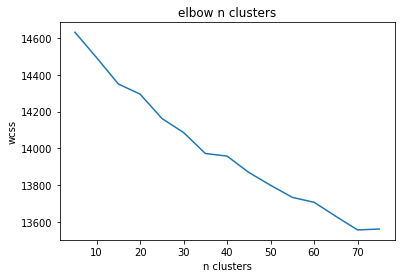

In [62]:
wcss = []
for i in range(5,80,5):
    kmeans_model = KMeans(n_clusters=i, random_state=0)
    kmeans_model.fit_transform(tfidf_vecs)
    wcss.append(kmeans_model.inertia_)
plt.plot(range(5,80,5),wcss)
plt.title('elbow n clusters')
plt.xlabel('n clusters')
plt.ylabel('wcss')
plt.show()

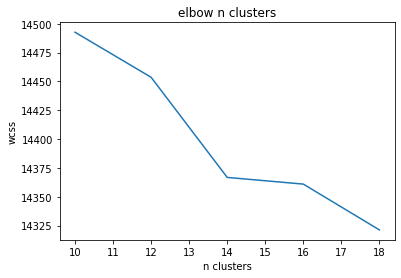

In [65]:
wcss = []
for i in range(10,20,2):
    kmeans_model = KMeans(n_clusters=i, random_state=0)
    kmeans_model.fit_transform(tfidf_vecs)
    wcss.append(kmeans_model.inertia_)
plt.plot(range(10,20,2),wcss)
plt.title('elbow n clusters')
plt.xlabel('n clusters')
plt.ylabel('wcss')
plt.show()

In [69]:
kmeans_model = KMeans(n_clusters=14, random_state=0)
kmeans_model.fit_transform(tfidf_vecs)
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
pd.DataFrame([[terms[i] for i in order_centroids[j]] for j in range(len(order_centroids))],
                          index=[f'Topic {x}' for x in range(14)]).iloc[:,:9]

,0,1,2,3,4,5,6,7,8
Topic 0,usa_uk,eu_australia,digital_qr,send_dm,qr_scan,passport_taking,card_taking,certificate_paper,link_join
Topic 1,biden,trump,died,nolte_dead,corona,president,via_breitbartnews,death,foxnews_speakerpelosi
Topic 2,thread,read,whole,great,good,important,entire,interesting,please
Topic 3,sorry,therealrhllor,condolence,loss,aunt,chaplain,deepest_condolence,heartbreaking,family
Topic 4,every,mask,mandate,know,sick,ting,back,school,person
Topic 5,think,safe,kreekcraft_stay,know,actually,death,good,safe_kreek,realcandaceo
Topic 6,know,ting,realcandaceo,repvaldemings,health,died,good,boosted,please
Topic 7,kreekcraft,hope,stay_safe,kreek,hopefully,better_soon,kayla,fine,feel
Topic 8,sorry_loss,therealrhllor,aunt,condolence,sorry_hear,memory_blessing,thank,flipncblue_potus,exceedhergrasp
Topic 9,pfizer,document,moderna,pregnant_woman,merryjayne_smellingstonky,jonzy_cryptogardeners,released,trial,dump


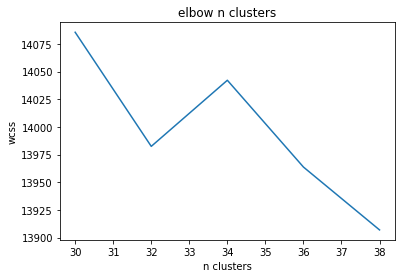

In [64]:
wcss = []
for i in range(30,40,2):
    kmeans_model = KMeans(n_clusters=i, random_state=0)
    kmeans_model.fit_transform(tfidf_vecs)
    wcss.append(kmeans_model.inertia_)
plt.plot(range(30,40,2),wcss)
plt.title('elbow n clusters')
plt.xlabel('n clusters')
plt.ylabel('wcss')
plt.show()

In [70]:
kmeans_model = KMeans(n_clusters=32, random_state=0)
kmeans_model.fit_transform(tfidf_vecs)
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
pd.DataFrame([[terms[i] for i in order_centroids[j]] for j in range(len(order_centroids))],
                          index=[f'Topic {x}' for x in range(32)]).iloc[:,:9]

,0,1,2,3,4,5,6,7,8
Topic 0,usa_uk,eu_australia,digital_qr,send_dm,qr_scan,passport_taking,card_taking,certificate_paper,link_join
Topic 1,work,card,mask,qr_code,enabled_any,certificate_bosster,provide_registered,penny_curtis,passport
Topic 2,help,give,thrasherxy,please,ting,back,thank,resident,government
Topic 3,every,know,death,ting,government,sick,family,some,work
Topic 4,know,pfizer,died,document,pregnant_woman,trial,moderna,ting,dump
Topic 5,think,actually,work,know,death,some,mask,government,ting
Topic 6,child,houstonchron_sentedcruz,caylajharris_dispatchalerts,parent,military,hepatitis,risk,crore,administered
Topic 7,ting,mask,health,country,miltu_jedediahbila,mandate,pandemic,please,died
Topic 8,corona,nolte_dead,biden,via_breitbartnews,coronatips,news,health,here,worry
Topic 9,boosted,fully,producer_hid,nathanmackbrown,evidence,problem,report,symptom,family
